# Firing Rates and Tuning Curves

One way to summarize the important aspects of what a neuron "does" is to summarize how it responds to a variety of inputs. We're going to use [the LIF model from before](./05%20-%20Implementing%20Firing.ipynb):

In [1]:
class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output

So let's see what happens if we input a *constant* current. We're going to create a LIF neuron with parameters $\tau_{rc} = 0.02$ and $\tau_{ref} = 0.2$ and plot the spikes of our LIF neuron given a constant inputs of varying intensities.

Let's see what happens when we call our function with an input *slightly* over 1A (`1.0000001`):

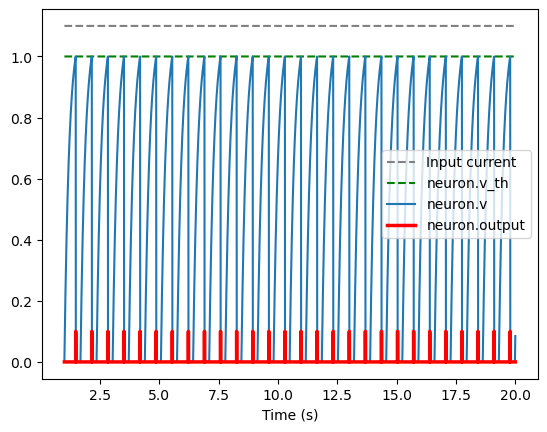

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def fullPlot(I):
    duration = 20  # Duration of the simulation
    T_step = 0.001 # Time step size
    times = np.arange(1, duration, T_step) # Create a range of time values

    neuron = FirstOrderLIF(tau_ref = 0.2) # Create a new LIF neuron

    I_history = []
    v_history = []
    output_history = []
    vth_history = []

    for t in times: # Iterate over each time step
        neuron.step(I, T_step) # Advance the neuron one time step

        I_history.append(I)    # Record the input current
        v_history.append(neuron.v) # Record the neuron's potential
        output_history.append(neuron.output * T_step / 10) # Record the neuron's output (scaled)
        vth_history.append(neuron.v_th) # Record the neuron's threshold


    plt.figure() # Create a new figure
    plt.plot(times, I_history, color="grey", linestyle="--")
    plt.plot(times, vth_history, color="green", linestyle="--")
    plt.plot(times, v_history)
    plt.plot(times, output_history, color="red", linewidth=2.5)
    plt.xlabel('Time (s)') # Label the x-axis
    plt.legend(['Input current', 'neuron.v_th', 'neuron.v', 'neuron.output']) # Add a legend
    plt.show() # Display the plot

fullPlot(1.1) # Run the simulation with an input current of 1.1

If we don't have sufficient input (for example, if `I` is `0.95`), our neuron never fires

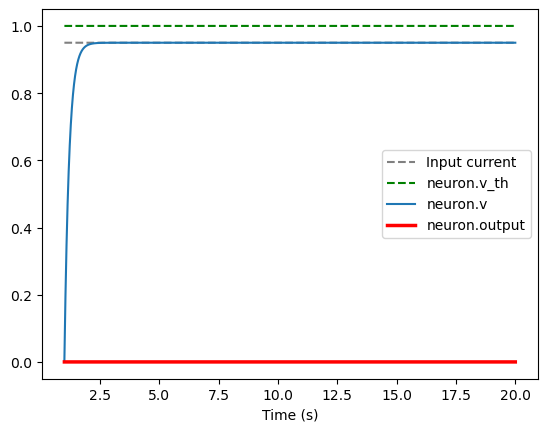

In [15]:
fullPlot(I = 0.95)

---


We don't really need to see anything but the spikes, so let's create a different view of these with only the spikes. If we put our input `I` to be *barely* above `1` (to `1.0000001`), our neuron will fire again:

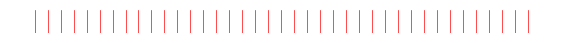

'An input of 1.0000001 produces 39 spikes in 20 seconds (1.95 Hz)'

In [8]:
import matplotlib.pyplot as plt

def plotSpikes(neuron, duration, t_step, input_current):
    # Lists to record spike times and membrane potential
    spike_times = []
    time_points = []

    # Run the simulation
    time = 0.0
    while time < duration:
        output = neuron.step(input_current, t_step)
        time_points.append(time)
        if output > 0:  # neuron fires a spike
            spike_times.append(time)
        time += t_step

    # Plot the spikes as vertical lines
    plt.figure(figsize=(7, 0.3))
    for spike_time in spike_times:
        plt.axvline(x=spike_time, color='red', linewidth=0.5)

    plt.axis('off')  # Turn off the axes

    # Calculate and display the output message
    num_spikes = len(spike_times)
    spike_rate = num_spikes / duration
    output_message = f"An input of {input_current} produces {num_spikes} spikes in {duration} seconds ({spike_rate:.2f} Hz)"

    plt.show()
    return output_message

plotSpikes(FirstOrderLIF(tau_rc=0.02, tau_ref=0.2), duration=20, t_step=0.001, input_current=1.0000001)

We can see that our neuron fires *about* twice per second, making its firing rate ~2Hz. If we increase our input to `1.1`, we can see that it fires more frequently:

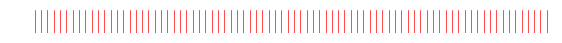

'An input of 1.1 produces 82 spikes in 20 seconds (4.10 Hz)'

In [9]:
plotSpikes(FirstOrderLIF(tau_rc=0.02, tau_ref=0.2), duration=20, t_step=0.001, input_current=1.1)

Increase it some more (to `10`), and it will fire even more frequently.

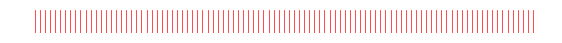

'An input of 10 produces 99 spikes in 20 seconds (4.95 Hz)'

In [10]:
plotSpikes(FirstOrderLIF(tau_rc=0.02, tau_ref=0.2), duration=20, t_step=0.001, input_current=10)

But we can only increase it so much, thanks to the refractory time. If we increase our incoming current significantly (to `100`), our spike frequency barely changes:

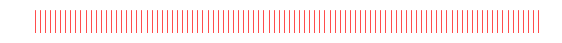

'An input of 100 produces 100 spikes in 20 seconds (5.00 Hz)'

In [16]:
plotSpikes(FirstOrderLIF(tau_rc=0.02, tau_ref=0.2), duration=20, t_step=0.001, input_current=100)

However, if we don't input enough current, our neuron never spikes, as the potential leaks out faster than it can be added.

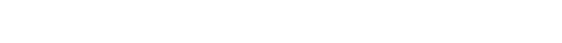

'An input of 0.8 produces 0 spikes in 20 seconds (0.00 Hz)'

In [12]:
plotSpikes(FirstOrderLIF(tau_rc=0.02, tau_ref=0.2), duration=20, t_step=0.001, input_current=0.8)

As we can see, different inputs lead to different spike frequencies. We can plot this relationship between input and output as a graph, which is called a tuning curve. Let's plot the tuning curve of our neuron, where the x-axis is the input current and the y-axis is the output firing rate:

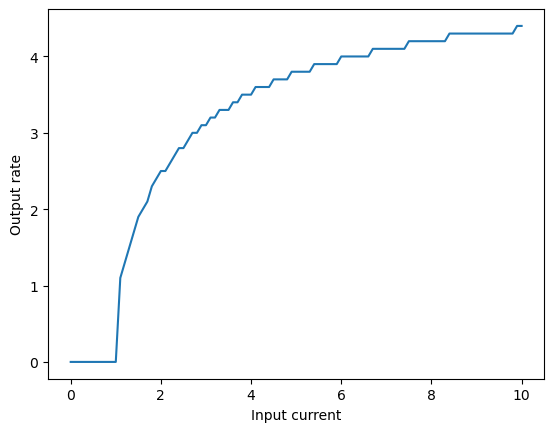

In [22]:
def getSpikeRate(neuron, I, numSeconds=10, T_step=0.001):
    """
    Get the spike rate of a neuron for a given input current
    """
    count = 0 # Will store the number of spikes
    numSteps = int(numSeconds / T_step) # How many times we need to call step()

    for _ in range(numSteps):
        output = neuron.step(I, T_step)
        if output > 0: # If the neuron fired a spike, add it to our cou nt
            count += 1

    return count / numSeconds # To get the *rate*, divide by the number of seconds

inputs = np.arange(0, 10.1, 0.1) # Create a range of input values (0 to 10.1)
output_rates = []

for inp in inputs: # Iterate over each input value
    output_rate = getSpikeRate(FirstOrderLIF(tau_rc=0.3, tau_ref=0.2), inp) # Get the spike rate for that input
    output_rates.append(output_rate) # Store the output rate

plt.figure() # Create a new figure
plt.plot(inputs, output_rates) # Plot the input rates
plt.xlabel('Input current') # Label the x-axis
plt.ylabel('Output rate') # Label the y-axis
plt.show() # Display the plot


In the code above, we calculated the output rate with the `getSpikeRate` function, which "runs" the neuron with a given input to get the spike rate for input $I$, $r(I)$:

$$
r(I) =
\begin{cases}
  0 & \text{if } I \leq v_{th}\\
  \frac{1}{\tau_{ref}-\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}} & \text{otherwise}
\end{cases}
$$(eq:analytical-rate)

:::{dropdown} How did we get this formula?
# (Optional) Analytically Computing LIF Responses

Recall our equation defining $v'(t)$ {eq}`eq:vprime`:

$$v'(t) = \frac{1}{\tau_{rc}}I(t) - \frac{1}{\tau_{rc}}v(t)$$

When we have a function whose rate of change is proportional to its value (as $v(t)$ is), we call it an *exponential* function. For example, $e^x$ is an exponential function because its derivative is itself: $\frac{de^x}{dx} = e^x$. In this case, $v(t)$ *decays* exponentially (as opposed to growing exponentially), which is the case when $x < 0$.

So generally, whenever we have a rate of change of something (in this case, $v'(t)$) that is proportional to the thing itself (in this case, $v(t)$), there's a good chance that the solution involves either $e^{...}$ or $sin(...)$, whose derivatives are proportional to themselves (and are related by Euler's formula). Coming back to our function, one definition of $v(t)$ that satisfies our constraints is:

$$v(t) = I(t) + (v(t-\Delta{}t) - I(t))e^{-\frac{\Delta{}t}{\tau_{rc}}}$$

If we want to compute the time that it takes to get from $v = 0$ to the firing threshold $v = v_{th}$ under a constant input current $I$, we first need to assume that the input current is high enough: $I > v_{th}$. Then, we can solve for how long it takes to reach $v_{th}$ (which we will call $t_{th}$), we can sub in $t_{th}$ for $\Delta{}t$, $0$ for $v(t)$, and $v_{th}$ for $v(t)$ in the above formula:

$$v_{th} = I + (0 - I)e^{-\frac{t_{th}}{\tau_{rc}}}$$

Moving terms around, we get:

$$e^{-\frac{t_{th}}{\tau_{rc}}} = 1 - \frac{v_{th}}{I}$$

giving us:

$$t_{th} = -\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}$$

To compute the time that it takes to fire and recover, we need to add the refractory time ($\tau_{ref}$). This means the time that it takes to fire is:

$$\tau_{ref}-\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}$$

and to get the firing rate $r(I)$ for a given input $I$, we take its inverse:

$$r(I) = \frac{1}{\tau_{ref}-\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}}$$

However, all of this only applies if $I > v_{th}$, leaving us with the final equation:

$$
r(I) =
\begin{cases}
  0 & \text{if } I \leq v_{th}\\
  \frac{1}{\tau_{ref}-\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}} & \text{otherwise}
\end{cases}
$$

:::

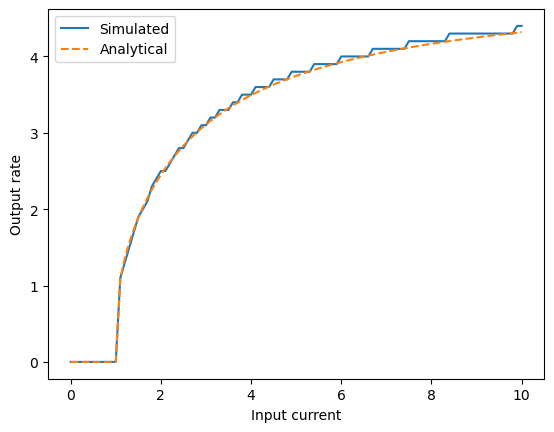

In [33]:
import numpy as np

def analyticalRate(neuron, I):
    if I <= neuron.v_th:
        return 0
    else:
        return 1 / (neuron.tau_ref - neuron.tau_rc * np.log(1 - neuron.v_th/I))

plt.figure() # Create a new figure
plt.plot(inputs, output_rates) # Plot the input rates
plt.plot(inputs, [analyticalRate(FirstOrderLIF(tau_rc=0.3, tau_ref=0.2), I) for I in inputs], color="C1", linestyle="--") # Plot the analytical rates
plt.xlabel('Input current') # Label the x-axis
plt.ylabel('Output rate') # Label the y-axis
plt.legend(['Simulated', 'Analytical']) # Add a legend
plt.show() # Display the plot

This looks like a good match! The firing rate that we computed analytically matches what we observe in the simulation.

Now, try modifying the LIF parameters below (`tau_ref`, `tau_rc`, and `v_th`) and see how the tuning curve changes.

```{editor} python
:packages: matplotlib,numpy
:run_on_load: true
:max_height: 600px

import matplotlib.pyplot as plt
import numpy as np

tau_ref = 0.200 # <-SLIDE(0 to 2 by 0.001)
tau_rc  = 0.300 # <-SLIDE(0.1 to 1 by 0.001)
v_th    = 1.00  # <-SLIDE(0.1 to 5 by 0.01)

def analyticalRate(neuron, I):
    if I <= neuron.v_th:
        return 0
    else:
        return 1 / (neuron.tau_ref - neuron.tau_rc * np.log(1 - neuron.v_th/I))

class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output

neuron = FirstOrderLIF(tau_rc=tau_rc, tau_ref=tau_ref, v_th=v_th)

inputs = np.arange(0, 10.1, 0.01)
output_rates = [analyticalRate(neuron, i) for i in inputs]

plt.figure()
plt.plot(inputs, output_rates)
plt.xlabel('Input current') # Label the x-axis
plt.ylabel('Output rate') # Label the y-axis
plt.show()
```

So we can see that our neuron does not react to current until it reaches $v_{th}$. At that point, it starts firing and its firing rate is proportional to the incoming current. The firing rate eventually flattens out, thanks to the refractory time (the period where the neuron can't fire).

## Summary

- A tuning curve summarizes a neuron's response (in the form of a firing rate) to a variety of inputs
- Neurons start firing at the threshold potential $v_{th}$ and the firing rate rises as the input increases (but rises at a decreasing rate)
- As long as there is some refractory time, our neuron's firing rate will "flatten" out to a maximum value

## References

- Chris Eliasmith's [Neural Engineering book](https://mitpress.mit.edu/9780262550604/neural-engineering/) contains the derivation used for analytically computing LIF responses
- [The Nengo summer school lectures](https://www.youtube.com/watch?v=JCA2gOhN5oM&list=PLYLu6sY3jnoXTrkfA_WMn0nF_FGz-MaiJ&index=2) clearly describe how tuning curves work